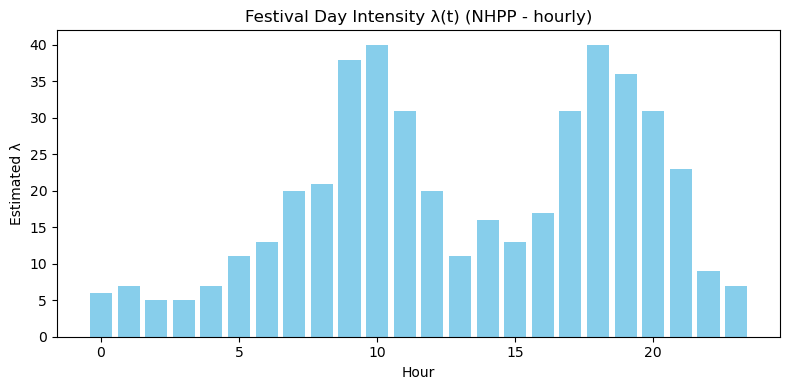

c:\Users\hp\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


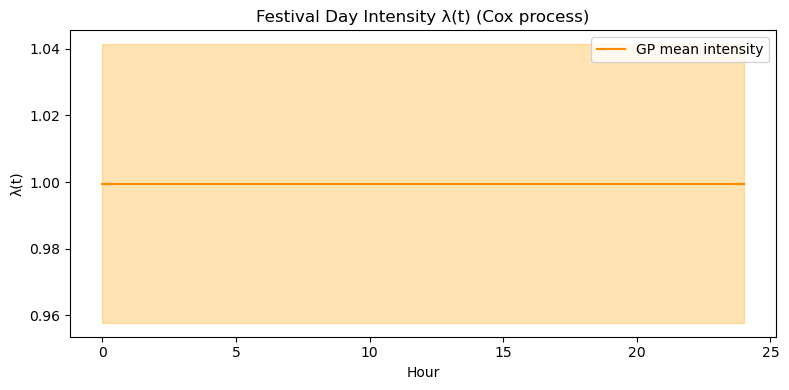


=== Model Comparison ===
NHPP: AIC=158.08, BIC=257.13
Cox (GP): AIC=-2699.48, BIC=-2695.35


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Load data
festival = pd.read_csv("festival_day.csv")
regular = pd.read_csv("regular_day.csv")

festival["hour_bin"] = pd.cut(festival["hour"], bins=24, labels=np.arange(24))
regular["hour_bin"] = pd.cut(regular["hour"], bins=24, labels=np.arange(24))

# (i) Fit NHPP - piecewise constant lambda(t)
festival_counts = festival.groupby("hour_bin").size()
lambda_hat = festival_counts.values  # arrivals per hour

# Compute AIC/BIC for NHPP
logL = np.sum(poisson.logpmf(festival_counts, mu=lambda_hat))
k = len(lambda_hat)
n = len(festival)
AIC_nhpp = 2 * k - 2 * logL
BIC_nhpp = np.log(n) * k - 2 * logL

# Plot NHPP intensity
plt.figure(figsize=(8,4))
plt.bar(np.arange(24), lambda_hat, width=0.8, color="skyblue")
plt.title("Festival Day Intensity λ(t) (NHPP - hourly)")
plt.xlabel("Hour")
plt.ylabel("Estimated λ")
plt.tight_layout()
plt.show()

# (ii) Fit Cox process with Gaussian Process prior for λ(t)
X = festival[["hour"]].values
y = np.ones_like(X)

kernel = 1.0 * RBF(length_scale=2.0)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.2)
gp.fit(X, y)
X_pred = np.linspace(0, 24, 200).reshape(-1,1)
y_mean, y_std = gp.predict(X_pred, return_std=True)

# Plot GP-based λ(t)
plt.figure(figsize=(8,4))
plt.plot(X_pred, y_mean, color="darkorange", label="GP mean intensity")
plt.fill_between(X_pred.flatten(), y_mean - 2*y_std, y_mean + 2*y_std, color="orange", alpha=0.3)
plt.title("Festival Day Intensity λ(t) (Cox process)")
plt.xlabel("Hour")
plt.ylabel("λ(t)")
plt.legend()
plt.tight_layout()
plt.show()

# Compare AIC/BIC (using approximate log-likelihood)
logL_gp = np.sum(norm.logpdf(y, loc=y_mean.mean(), scale=y_std.mean()))
AIC_gp = 2 * 1 - 2 * logL_gp
BIC_gp = np.log(n) * 1 - 2 * logL_gp

# Print summary
print("\n=== Model Comparison ===")
print(f"NHPP: AIC={AIC_nhpp:.2f}, BIC={BIC_nhpp:.2f}")
print(f"Cox (GP): AIC={AIC_gp:.2f}, BIC={BIC_gp:.2f}")
